# assignment_1b question 3

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 3: N-Layer and Dropout](#n_layer_and_dropout)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Try Test Set](#try_test_set) 
        * [5-Layer](#5_layer)
        * [5-Layer Dropout](#5_layer_dropout)    
        * [4-Layer](#4_layer)    
        * [4-Layer Dropout](#4_layer_dropout)        
        * [3-Layer](#3_layer)     
        * [Save Data Objects](#save_data_objects)
        * [Plot Model Performance](#plot_model_performance)
        * [Comparing Models](#comparing_models)
        * [Eyeballing Network and Dropout](#eyeballing_rfe_feature_space)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import itertools

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [4]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [5]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### histories_loader()

In [6]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### TestCallback()

In [7]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, mse = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['mse'].append(mse)
        histories_test['test_values']['loss'].append(loss)

# Question 3: N-Layer and Dropout  <a name="n_layer_and_dropout"></a>
[Back to top](#toc)

<i>Design a four-layer neural network and a five-layer neural network, with the hidden layers having 50 neurons each. Use a learning rate of 10-3 for all layers and optimal feature set selected in part (3). Introduce dropouts (with a keep probability of 0.8) to the layers and report the accuracies. Compare the performances of all the networks (with and without dropouts) with each other and with the 3-layer network.</i>

Essentially we have to build five networks on the optimal feature set from assignment_1b_q2
* 3-layer network no dropout (from assignment_1b_q2)
* 4-layer network no dropout
* 4-layer network with dropout
* 5-layer network no dropout
* 5-layer network with dropout

There may be some trouble later when evaluating these five models, since the 3-layer network in assignment_1b_q2 was built with 10 neurons

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [8]:
num_neurons = 50

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)
dropout_rate = 0.2

learning_rate= 10e-3
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
metrics = ['mse']

validation_split = 0.3
epochs = 400 # from assignment_1b_q1
batch_size = 8

callbacks = [TqdmCallback(verbose=1)]

print("Model Parameters set")

Model Parameters set


The optimal feature set from assignment_1b q2 is a 6 input feature set, which dropped ```SOP```, the 4th column. We shall truncate the data as such 

In [9]:
X_train_truncated = np.delete(X_train, 3, 1)
X_test_truncated = np.delete(X_test, 3, 1)
print("X_train_truncated, X_test_truncated generated")

X_train_truncated, X_test_truncated generated


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [10]:
def create_model_3(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_4(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_4_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_5(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

def create_model_5_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dropout(rate=dropout_rate, seed=seed),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [11]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### 4-Layer <a name="4_layer"></a> 
[Back to top](#toc)

### 4-Layer <a name="4_layer"></a> 
[Back to top](#toc)

### 4-Layer <a name="4_layer"></a> 
[Back to top](#toc)

# Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use a truncated ```X_test``` to check the performance of the model on the test set, by only using the ```CGPA``` column

### 5-Layer <a name="5_layer"></a> 
[Back to top](#toc)

In [12]:
# the optimized parameter and custom callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_5 = {}

In [13]:
model = create_model_5(num_neurons, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_5, histories_final_5[model_name] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_5, "data/q3_histories_final_5.json")
histories_final_5 = histories_loader("data/q3_histories_final_5.json")

histories_final_5['test_values'] = histories_test['test_values']

histories_saver(histories_final_5, "data/q3_histories_final_5.json", already_json=True)
histories_final_5 = histories_loader("data/q3_histories_final_5.json")


Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


### 5-Layer Dropout <a name="5_layer_dropout"></a> 
[Back to top](#toc)

In [14]:
# the optimized parameter and custom callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_5_dropout = {}

In [16]:
model = create_model_5_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed)
model_name = 'train_values'
model_5_dropout, histories_final_5_dropout[model_name] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_5_dropout, "data/q3_histories_final_5_dropout.json")
histories_final_5_dropout = histories_loader("data/q3_histories_final_5_dropout.json")

histories_final_5_dropout['test_values'] = histories_test['test_values']

histories_saver(histories_final_5_dropout, "data/q3_histories_final_5_dropout.json", already_json=True)
histories_final_5_dropout = histories_loader("data/q3_histories_final_5_dropout.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


### 4-Layer <a name="4_layer"></a> 
[Back to top](#toc)

In [17]:
# the optimized parameter and custom callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_4 = {}

In [18]:
model = create_model_4(num_neurons, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_4, histories_final_4[model_name] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_4, "data/q3_histories_final_4.json")
histories_final_4 = histories_loader("data/q3_histories_final_4.json")

histories_final_4['test_values'] = histories_test['test_values']

histories_saver(histories_final_4, "data/q3_histories_final_4.json", already_json=True)
histories_final_4 = histories_loader("data/q3_histories_final_4.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


### 4-Layer Dropout <a name="4_layer_dropout"></a> 
[Back to top](#toc)

In [19]:
# the optimized parameter and custom callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_4_dropout = {}

In [20]:
model = create_model_4_dropout(num_neurons, regularization, optimizer, loss, metrics, dropout_rate, seed)
model_name = 'train_values'
model_4_dropout, histories_final_4_dropout[model_name] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_4_dropout, "data/q3_histories_final_4_dropout.json")
histories_final_4_dropout = histories_loader("data/q3_histories_final_4_dropout.json")

histories_final_4_dropout['test_values'] = histories_test['test_values']

histories_saver(histories_final_4_dropout, "data/q3_histories_final_4_dropout.json", already_json=True)
histories_final_4_dropout = histories_loader("data/q3_histories_final_4_dropout.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


### 3-Layer <a name="3_layer"></a> 
[Back to top](#toc)

The 3-layer network only differs in ```num_neurons=10``` and having no dropout

In [24]:
# the optimized parameter and custom callback
num_neurons = 10
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test_truncated, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_3 = {}

In [25]:
model = create_model_3(num_neurons, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_3, histories_final_3[model_name] = fit_model(X_train_truncated, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_3, "data/q3_histories_final_3.json")
histories_final_3 = histories_loader("data/q3_histories_final_3.json")

histories_final_3['test_values'] = histories_test['test_values']

histories_saver(histories_final_3, "data/q3_histories_final_3.json", already_json=True)
histories_final_3 = histories_loader("data/q3_histories_final_3.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


##### Plotting Test Set

In [27]:
histories_final = {'3_layer': histories_final_3,
                    '4_layer': histories_final_4,
                    '4_layer_dropout': histories_final_4_dropout,
                    '5_layer': histories_final_5,
                    '5_layer_dropout': histories_final_5_dropout}

histories_saver(histories_final, "data/q3_histories_final.json", already_json=True)
histories_final = histories_loader("data/q3_histories_final.json")

Histories saved
Histories loaded


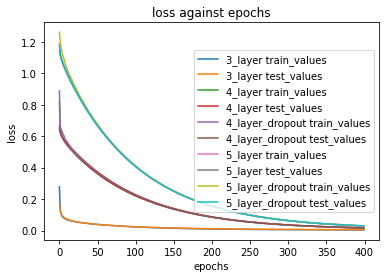

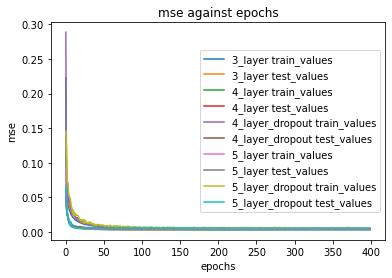

In [28]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        for value_type in histories_final[model_name].keys():
            plt.plot(histories_final[model_name][value_type][history_object], label=model_name + ' ' + value_type)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

Zooming in on the tail and just focusing on the test_values

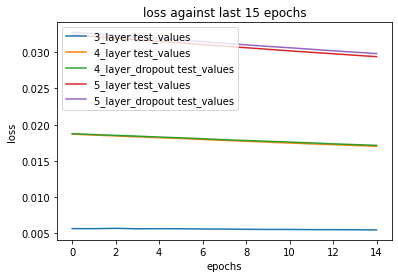

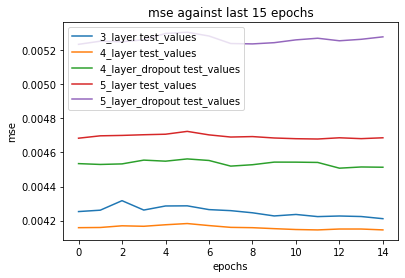

In [30]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name]['test_values'][history_object][-15:], label=model_name + ' ' + value_type)
#         for value_type in histories_final[model_name].keys():
#             plt.plot(histories_final[model_name][value_type][history_object][-15:], label=model_name + ' ' + value_type)

    plt.title(history_object + ' against last 15 epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="upper left")
    plt.show()

> ### 4_layer, no dropout has the best model that generalizes to the test set

The smallest ```test mse``` belong to the the 4 layer, no dropout, which is closely followed by 3 layer, no dropout 

##### Visualize Test Predictions <a name="visualize_test_predictions"></a> 
[Back to top](#toc)

In [31]:
Y_test_pred_5 = model_5.predict(X_test_truncated)
Y_test_pred_5 = Y_test_pred_5.reshape(1,120)[0]

Y_test_pred_5_dropout = model_5_dropout.predict(X_test_truncated)
Y_test_pred_5_dropout = Y_test_pred_5_dropout.reshape(1,120)[0]

Y_test_pred_4 = model_4.predict(X_test_truncated)
Y_test_pred_4 = Y_test_pred_4.reshape(1,120)[0]

Y_test_pred_4_dropout = model_4_dropout.predict(X_test_truncated)
Y_test_pred_4_dropout = Y_test_pred_4_dropout.reshape(1,120)[0]

Y_test_pred_3 = model_3.predict(X_test_truncated)
Y_test_pred_3 = Y_test_pred_3.reshape(1,120)[0]

In [32]:
df_Y_test_pred_5 = pd.DataFrame(Y_test_pred_5, columns =['Y_test_pred_5']) 
df_Y_test_pred_5_dropout = pd.DataFrame(Y_test_pred_5_dropout, columns =['Y_test_pred_5_dropout']) 
df_Y_test_pred_4 = pd.DataFrame(Y_test_pred_4, columns =['Y_test_pred_4']) 
df_Y_test_pred_4_dropout = pd.DataFrame(Y_test_pred_4_dropout, columns =['Y_test_pred_4_dropout']) 
df_Y_test_pred_3 = pd.DataFrame(Y_test_pred_3, columns =['Y_test_pred_3']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred_5, df_Y_test_pred_5_dropout, df_Y_test_pred_4, df_Y_test_pred_4_dropout, df_Y_test_pred_3, df_Y_test], axis=1)

In [33]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred_5,Y_test_pred_5_dropout,Y_test_pred_4,Y_test_pred_4_dropout,Y_test_pred_3,Y_test
45,0.743482,0.740773,0.739177,0.737555,0.749692,0.77
79,0.567236,0.574625,0.532021,0.548207,0.550614,0.44
56,0.735969,0.731984,0.733694,0.730316,0.707070,0.75
85,0.662250,0.672826,0.666535,0.671848,0.657904,0.62
99,0.661830,0.672917,0.650906,0.656452,0.652754,0.50


##### First view: plotting pred+ground_truth pairs

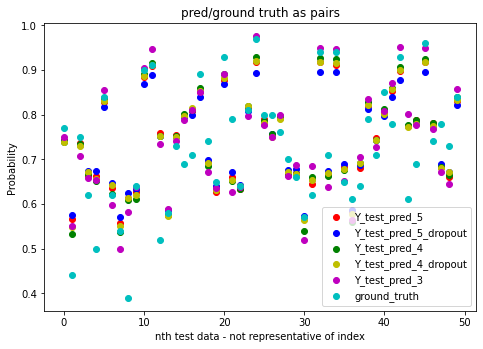

In [41]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_5'], color='r', label='Y_test_pred_5')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_5_dropout'], color='b', label='Y_test_pred_5_dropout')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_4'], color='g', label='Y_test_pred_4')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_4_dropout'], color='y', label='Y_test_pred_4_dropout')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred_3'], color='m', label='Y_test_pred_3')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='c', label='ground_truth')

ax.set_title('pred/ground truth as pairs')
ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Second view: predicted value against ground truth

If a datapoint lies on the y=x line, it represents a perfect prediction

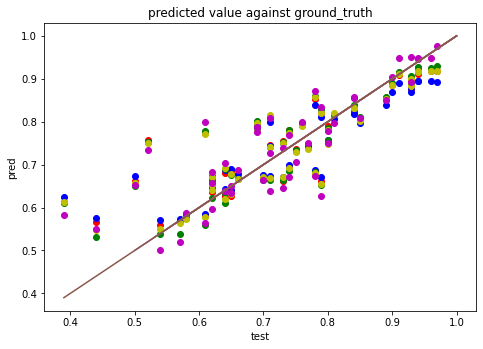

In [42]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_5'], color='r')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_5_dropout'], color='b')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_4'], color='g')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_4_dropout'], color='y')
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred_3'], color='m')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))

ax.set_title('predicted value against ground_truth')
ax.set_xlabel('test')
ax.set_ylabel('pred')
plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> Optimal model is with a 4-layer network with 50 neurons/layer, no dropout

Of course, this combination is due to the question. There might be better networks, just that we have not tried the combinations yet